# Exploring recipe's calories using two different data sources.

We have calories data from 2 different columns: `nutrition`, `derived_nutrition`.

We want to compare the values from both sources.

In [1]:
reset -fs

In [2]:
import re
import json
import pprint
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import datalab.bigquery as bq
import matplotlib.pyplot as plt
sns.set_style('white')
%matplotlib inline

To be able to see all content columns of a pandas dataframe, we set the width of the columns to max.

In [3]:
pd.set_option('display.max_colwidth', -1)

To be able to see all numeric data with 2 decimals instead of scientific notation.

In [4]:
pd.options.display.float_format = '{:.2f}'.format

To explore the data schema from the table we will extract data.

In [5]:
%bigquery schema --table firebase-wellio:recipes.imported_recipes

Extracting `derived_nutrition_version`.

Example of a row of data:

```
{"name": "Alcohol, ethyl", "nutrient_id": "221", "unit": "g", "agg_value": 0.0}	 
{"name": "Caffeine", "nutrient_id": "262", "unit": "mg", "agg_value": 0.0}	 
{"name": "Calcium, Ca", "nutrient_id": "301", "unit": "mg", "agg_value": 1313.3905300353488}	 
{"name": "Carbohydrate, by difference", "nutrient_id": "205", "unit": "g", "agg_value": 162.99052465576816}	 
{"name": "Cholesterol", "nutrient_id": "601", "unit": "mg", "agg_value": 375.9498823787561}	 
{"name": "Energy", "nutrient_id": "208", "unit": "kcal", "agg_value": 2333.1553278007873}	 
{"name": "Fatty acids, total monounsaturated", "nutrient_id": "645", "unit": "g", "agg_value": 45.812315539385196}	 
{"name": "Fatty acids, total polyunsaturated", "nutrient_id": "646", "unit": "g", "agg_value": 23.205340564004327}	 
{"name": "Fatty acids, total saturated", "nutrient_id": "606", "unit": "g", "agg_value": 49.405855655327926}	 
{"name": "Fatty acids, total trans", "nutrient_id": "605", "unit": "g", "agg_value": 0.03039770861878195}	 
{"name": "Fiber, total dietary", "nutrient_id": "291", "unit": "g", "agg_value": 30.928357548404282}	 
{"name": "Iron, Fe", "nutrient_id": "303", "unit": "mg", "agg_value": 14.117875369935824}	 
{"name": "Magnesium, Mg", "nutrient_id": "304", "unit": "mg", "agg_value": 323.6146339264634}	 
{"name": "Potassium, K", "nutrient_id": "306", "unit": "mg", "agg_value": 4182.024917283204}	 
{"name": "Protein", "nutrient_id": "203", "unit": "g", "agg_value": 134.36223258379204}	 
{"name": "Sodium, Na", "nutrient_id": "307", "unit": "mg", "agg_value": 3643.3221832455997}	 
{"name": "Sugars, total", "nutrient_id": "269", "unit": "g", "agg_value": 27.08103267541787}	 
{"name": "Total lipid (fat)", "nutrient_id": "204", "unit": "g", "agg_value": 133.7551269233669}	 
{"name": "Vitamin A, IU", "nutrient_id": "318", "unit": "IU", "agg_value": 49854.13482607046}	 
{"name": "Vitamin C, total absorbic acid", "nutrient_id": "401", "unit": "mg", "agg_value": 415.64417814608424}	 
{"name": "Vitamin E (alpha-tocopherol)", "nutrient_id": "323", "unit": "mg", "agg_value": 12.62523061622084}
```

In [6]:
%%sql --module derived_nutrition_versions
SELECT
INTEGER(RIGHT(derived_nutrition_version, LENGTH(derived_nutrition_version)-1)) AS nutrition_version
FROM [firebase-wellio:recipes.imported_recipes]
GROUP BY nutrition_version
ORDER BY nutrition_version DESC

In [7]:
%%bigquery execute -q derived_nutrition_versions

nutrition_version
10
9
8
7
6
5
2
""


Latest nutrition version is 10. We will need to specify this version in our BigQuery's to get only the recipes with such attribute and avoid duplicates.

#### Extracting calories from `derived_nutrition` column. Note that we use URLs from domain `epicurious.com` as they always have `derived_nutrition`.

In [8]:
%%sql --module epicurious_calories_derived_nutrition
SELECT url, derived_nutrition AS calories
FROM [firebase-wellio:recipes.imported_recipes]
WHERE url LIKE '%epicurious.com%' AND derived_nutrition IS NOT NULL AND INTEGER(RIGHT(derived_nutrition_version, 
  LENGTH(derived_nutrition_version)-1)) = 10 AND derived_nutrition LIKE '%"unit": "kcal"%'

In [9]:
%%bigquery execute -q epicurious_calories_derived_nutrition

url,calories
http://www.epicurious.com/recipes/food/views/trail-mix-porridge-51221010,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2801.4369239636235}"
http://www.epicurious.com/recipes/food/views/sweet-potato-biscuits-361850,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 945.0912792423167}"
https://www.epicurious.com/recipes/food/views/blackberry-buttermilk-panna-cottas-with-blackberry-compote-231818,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2395.832647538674}"
http://www.epicurious.com/recipes/member/views/stuffed-cherry-tomatoes-with-bacon-parmesan-and-parsley-52990631,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1086.6770975877698}"
http://www.epicurious.com/recipes/member/views/tomato-procini-and-pancetta-sauce-50002143,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1274.5541085366535}"
http://www.epicurious.com/recipes/food/views/new-york-pretzels-109221,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 878.5485057965766}"
http://www.epicurious.com/recipes/member/views/guajillo-salsa-52345461,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 885.699502733223}"
http://www.epicurious.com/recipes/member/views/sauteed-mushrooms-with-gremolata-50112315,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 418.4392846889966}"
http://www.epicurious.com/recipes/member/views/simple-brushetta-1209205,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1730.7883677431914}"
http://www.epicurious.com/recipes/member/views/pork-chops-with-gorgonzola-50010500,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1943.441568018175}"


Export data to pandas dataframe.

In [10]:
epicurious_derived_calories_df = bq.Query(epicurious_calories_derived_nutrition).to_dataframe()

How many rows of data?

In [11]:
epicurious_derived_calories_df.size

1307536

In [12]:
epicurious_derived_calories_df.head()

,url,calories
0,http://www.epicurious.com/recipes/food/views/pasta-with-kalamata-olives-and-roasted-cherry-tomato-sauce-106310,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 4149.496520086323}"
1,http://www.epicurious.com/recipes/food/views/trail-mix-porridge-51221010,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2801.4369239636235}"
2,http://www.epicurious.com/recipes/food/views/sweet-potato-biscuits-361850,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 945.0912792423167}"
3,http://www.epicurious.com/recipes/member/views/homemade-ranch-seasoning-powder-52831731,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 135.98512906179346}"
4,https://www.epicurious.com/recipes/member/views/grilled-veggie-and-chicken-salad-1205861,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 3712.9275878825683}"


Extracting numeric value of calories using regex.

In [13]:
epicurious_derived_calories_df['calories_amount'] = epicurious_derived_calories_df['calories'].str.extract('"agg_value": ([0-9]+.[0-9]+)', expand=True)

In [14]:
epicurious_derived_calories_df.head()

,url,calories,calories_amount
0,http://www.epicurious.com/recipes/food/views/pasta-with-kalamata-olives-and-roasted-cherry-tomato-sauce-106310,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 4149.496520086323}",4149.496520086323
1,http://www.epicurious.com/recipes/food/views/trail-mix-porridge-51221010,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2801.4369239636235}",2801.4369239636235
2,http://www.epicurious.com/recipes/food/views/sweet-potato-biscuits-361850,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 945.0912792423167}",945.0912792423167
3,http://www.epicurious.com/recipes/member/views/homemade-ranch-seasoning-powder-52831731,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 135.98512906179346}",135.98512906179346
4,https://www.epicurious.com/recipes/member/views/grilled-veggie-and-chicken-salad-1205861,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 3712.9275878825683}",3712.9275878825683


Converting new column into float data type.

In [15]:
epicurious_derived_calories_df['calories_amount'] = epicurious_derived_calories_df['calories_amount'].apply(pd.to_numeric)

Exploring basic statistics of the calories amount.

In [16]:
epicurious_derived_calories_df.describe()

,calories_amount
count,653768.00
mean,601105.01
std,42286165.70
min,0.00
25%,1448.94
50%,2507.33
75%,4000.59
max,3141855091.61


How many recipes have 0 calories?

In [24]:
epicurious_0_derived_calories_df = epicurious_derived_calories_df[epicurious_derived_calories_df['calories_amount'] == 0]

In [25]:
pd.value_counts(epicurious_0_derived_calories_df['calories_amount'].value_counts())

90    1
Name: calories_amount, dtype: int64

In [26]:
epicurious_0_derived_calories_df.size

270

How many recipes have more than 5,000 calories?

In [27]:
epicurious_5000_derived_calories_df = epicurious_derived_calories_df[epicurious_derived_calories_df['calories_amount'] > 5000]

In [29]:
epicurious_5000_derived_calories_df.size

317478

If we don't filter out extreme calories values, we don't get a very useful histogram.

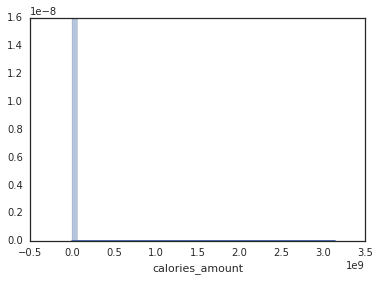

In [43]:
sns.distplot(epicurious_derived_calories_df['calories_amount']);

Let's create a dataframe with calories amount greater than 0 and less than 5,000.

In [22]:
epicurious_derived_calories_0_5000_df = epicurious_derived_calories_df[(epicurious_derived_calories_df['calories_amount'] > 0) & (epicurious_derived_calories_df['calories_amount'] < 5000)]

Now, let's visualize a distribution of the calories amount using the new created dataframe.

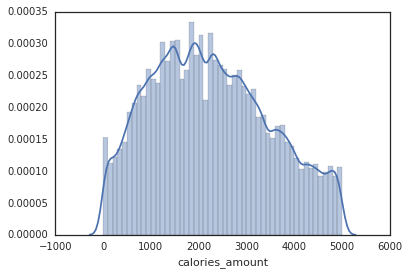

In [44]:
sns.distplot(epicurious_derived_calories_0_5000_df['calories_amount']);

#### Extracting calories from `nutrition` column. Note that we use URLs from domain `epicurious.com` as they always have `nutrition`.

One row of data looks like:

```
Calories 830.5	 
Calories from Fat 235	 
Total Fat 26.2 g	 
Saturated Fat 8.3 g	 
Cholesterol 75.1 mg	 
Sodium 1251.3 mg	 
Total Carbohydrate 103.2 g	 
Dietary Fiber 5.4 g	 
Sugars 5.3 g	 
Protein 43 g
```

In [32]:
%%sql --module epicurious_calories_nutrition
SELECT url, nutrition AS calories, FLOAT(RIGHT(nutrition, LENGTH(nutrition) - LENGTH('Calories'))) AS calories_amount
FROM FLATTEN([firebase-wellio:recipes.imported_recipes], nutrition)
WHERE url LIKE '%epicurious.com%' AND derived_nutrition IS NOT NULL AND INTEGER(RIGHT(derived_nutrition_version, 
  LENGTH(derived_nutrition_version)-1)) = 10 AND nutrition LIKE 'Calories%'
  AND nutrition NOT LIKE 'Calories from%'

In [33]:
%%bigquery execute -q epicurious_calories_nutrition

url,calories,calories_amount
http://www.epicurious.com/recipes/food/views/grilled-flank-steak-and-red-onion-with-orange-gremolata-12023,Calories 541,541.0
http://www.epicurious.com/recipes/member/views/savory-summer-pasta-1209541,Calories 294,294.0
http://www.epicurious.com/recipes/member/views/cannellini-bean-frittata-1246642,Calories 171,171.0
http://www.epicurious.com/recipes/member/views/pureed-cauliflower-soup-with-pancetta-and-gremolata-51539131,Calories 273,273.0
http://www.epicurious.com/recipes/food/views/red-bean-soup-with-gremolata-351299,Calories 277,277.0
http://www.epicurious.com/recipes/food/views/chicken-frico-with-gremolata-237906,Calories 568,568.0
http://www.epicurious.com/recipes/food/views/pasta-with-kalamata-olives-and-roasted-cherry-tomato-sauce-106310,Calories 556,556.0
http://www.epicurious.com/recipes/food/views/roasted-chicken-with-garbanzo-ragout-and-gremolata-230648,Calories 889,889.0
http://www.epicurious.com/recipes/member/views/caramelized-onion-and-chorizo-frittata-50048284,Calories 296,296.0
http://www.epicurious.com/recipes/member/views/sweet-potato-risotto-1242759,Calories 418,418.0


Export to pandas dataframe.

In [34]:
epicurious_calories_df = bq.Query(epicurious_calories_nutrition).to_dataframe()

Note. In case we want to perform sampling with BigQuery:
https://www.oreilly.com/learning/repeatable-sampling-of-data-sets-in-bigquery-for-machine-learning

In [35]:
epicurious_calories_df.head()

,url,calories,calories_amount
0,http://www.epicurious.com/recipes/food/views/grilled-flank-steak-and-red-onion-with-orange-gremolata-12023,Calories 541,541.00
1,http://www.epicurious.com/recipes/member/views/savory-summer-pasta-1209541,Calories 294,294.00
2,http://www.epicurious.com/recipes/member/views/cannellini-bean-frittata-1246642,Calories 171,171.00
3,http://www.epicurious.com/recipes/member/views/pureed-cauliflower-soup-with-pancetta-and-gremolata-51539131,Calories 273,273.00
4,http://www.epicurious.com/recipes/food/views/red-bean-soup-with-gremolata-351299,Calories 277,277.00


How many rows of data?

In [36]:
epicurious_calories_df.size

959565

Let's check the columns data types.

In [37]:
epicurious_calories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319855 entries, 0 to 319854
Data columns (total 3 columns):
url                319855 non-null object
calories           319855 non-null object
calories_amount    319855 non-null float64
dtypes: float64(1), object(2)
memory usage: 7.3+ MB


Checking basic statistics of the calories amount.

In [38]:
epicurious_calories_df.calories_amount.describe()

count   319855.00  
mean    1599.94    
std     189834.47  
min     0.00       
25%     256.00     
50%     389.00     
75%     691.00     
max     44659793.00
Name: calories_amount, dtype: float64

If we don't filter out extreme calories values, we don't get a very useful histogram.

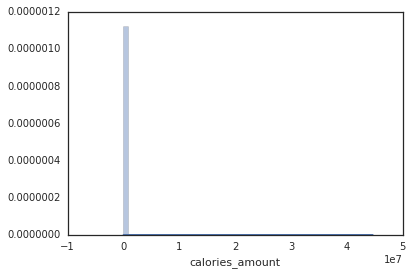

In [42]:
sns.distplot(epicurious_calories_df['calories_amount']);

Creating a dataframe with recipes with more than 0 calories and less than a 1,000 calories.

In [39]:
epicurious_calories_0_5000_df = epicurious_calories_df[(epicurious_calories_df['calories_amount'] > 0) & (epicurious_calories_df['calories_amount'] < 5000)]

And it's corresponding distribution plot.

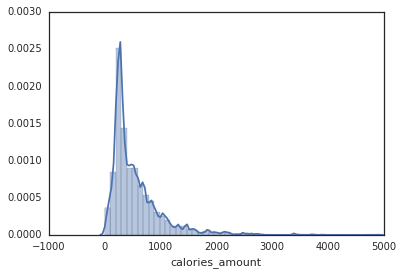

In [40]:
sns.distplot(epicurious_calories_0_5000_df['calories_amount']);

### We can see that the calories distribution is more extreme when using derived_nutrition compared to nutrition, and that where using nutrition, most of the recipes have a calories amount around 500 calories.